In [136]:
import pandas as pd
import requests
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import kruskal

## Extraindo dados da API da NOAA
Como o dataset está disponível apenas através da API disponibilizada pela NOAA *(National Oceanic and Atmospheric Administration)*, foi preciso registrar um **token** no site da agência, que foi enviado por email, para conseguir acessar a API

In [23]:
#config
token = "WZzNRktcksOxuQRDpDgdTyqlNgVkqtBd"
endpoint = "https://www.ncei.noaa.gov/access/services/data/v1"

params = {
    "dataset": "daily-summaries",
    "stations": "USW00023174",
    "startDate": "2024-03-07",
    "endDate": "2025-10-31",
    "format": "csv",
    "units": "metric"
}

#request
response = requests.get(endpoint, params=params, headers={"token": token})


Salvar o arquivo extraído da API em um .csv na pasta */data*

In [24]:
from pathlib import Path

root = Path.cwd() #sobe um nível (.parent) pra chegar na raiz v 
data_dir = root/ "data" #aponta pra pasta data/

save_csv = data_dir / "LA-wheather-daily-2024-2025.csv" #salva na pasta data/ 

#salva o arquivo extraído da API na pasta
with open (save_csv, "wb") as f:
    f.write(response.content)
    
print("Arquivo salvo em: ", save_csv)

df_global_hourly = pd.read_csv(r"data\LA-wheather-daily-2024-2025.csv")

Arquivo salvo em:  d:\gabri\Documents\IFSP\5_semestre\SPOESTA\projeto\data\LA-wheather-daily-2024-2025.csv


## Análise estatística

### Perguntas que serão respondidas com as análises:  
  
1. A média de crime diário aumenta quando está calor?
2. Qual a probabilidade de que em um dia chuvoso tenha crime acima da mediana?
3. Qual a probabilidade de que em um dia quente tenha crime acima da mediana?
4. Qual a probabilidade de que em um dia frio tenha crime acima da mediana?
5. A dispersão de crimes muda entre dias quentes, frio e chuvosos?


In [ ]:
#variáveis para os datasets

nibrs_offenses = pd.read_csv(r"data\LAPD_NIBRS_Offenses_Dataset.csv")
#nibrs_victims = pd.read_csv(r"data\LAPD_NIBRS_Victims_Dataset.csv")
wheather = pd.read_csv(r"data\LA-wheather-daily-2024-2025.csv")

## Limpeza e organização dos dados - NIBRS Offenses

In [ ]:
print(nibrs_offenses.dtypes)

In [ ]:
# alterando o tipo de dado para conseguir iniciar as análises

nibrs_offenses['Date OCC'] = pd.to_datetime(nibrs_offenses['Date OCC'])
nibrs_offenses['Date'] = nibrs_offenses['Date OCC'].dt.date #extrai apenas a data p/ comparar com o outro dataset que só tem yyyy-mm-dd

#criando a coluna de contagem de crimes por dia
daily_crimes = (
    nibrs_offenses.groupby('Date')['TotalOffenseCount'].sum() #agrupa a coluna ['TotalOffenseCount'] pelo critério ('Date') e soma tudo
    .reset_index() #pq 'Date' virou o índice
)
daily_crimes.columns = ['date', 'crime_count'] 

#pd.set_option("display.max_rows", None)
#daily_crimes

#daily_crimes.isna().sum()

## Limpeza e organização dos dados - NIBRS Offenses

In [ ]:
print(wheather.dtypes)

In [ ]:
wheather['DATE'] = pd.to_datetime(wheather['DATE'])
wheather['Date'] = wheather['DATE'].dt.date

dia_quente = 25 #25 graus Celsius

#criando lógica de dias quentes, chuvosos e frios
wheather['hot_day'] = wheather['TMAX'] >= dia_quente
wheather['cold_day'] = wheather['TMAX'] < dia_quente
wheather['rainy_day'] = wheather['PRCP'] > 0

#wheather['hot_day'].value_counts
#wheather['cold_day'].value_counts
#wheather['rainy_day'].value_counts

## Merge dos datasets

In [94]:
#INNER JOIN --> traz tudo das duas tabelas onde a data seja a mesma
final_df = daily_crimes.merge(
    wheather[['Date', 'TMAX', 'PRCP', 'hot_day', 'cold_day', 'rainy_day']],
    left_on='date',
    right_on='Date',
    how='inner'
)

final_df = final_df.drop(columns=['Date'])

#final_df.shape()
final_df.head()

,date,crime_count,TMAX,PRCP,hot_day,cold_day,rainy_day
0,2024-03-07,102,16.7,0.8,False,True,True
1,2024-03-08,83,20.6,0.0,False,True,False
2,2024-03-09,93,18.9,0.0,False,True,False
3,2024-03-10,118,17.8,0.0,False,True,False
4,2024-03-11,102,16.7,0.0,False,True,False


## Iniciando as análises estatísticas para responder as perguntas iniciais.

Análise descritiva

In [ ]:
hot_days = final_df[final_df['hot_day'] == True]['crime_count'] #filtra a contagem doscrimes onde os dias sejam quentes

hot_days.describe()

count     87.000000
mean     448.632184
std       71.780854
min      253.000000
25%      401.000000
50%      437.000000
75%      492.500000
max      629.000000
Name: crime_count, dtype: float64

In [93]:
cold_days = final_df[final_df['cold_day'] == True]['crime_count']

cold_days.describe()

count    517.000000
mean     447.433269
std      138.035939
min       75.000000
25%      390.000000
50%      467.000000
75%      543.000000
max      767.000000
Name: crime_count, dtype: float64

In [118]:
rainy_days = final_df[final_df['rainy_day'] == True]['crime_count']

rainy_days.describe()

count     39.000000
mean     433.769231
std      197.033054
min       83.000000
25%      230.000000
50%      522.000000
75%      566.000000
max      711.000000
Name: crime_count, dtype: float64

Boxplot

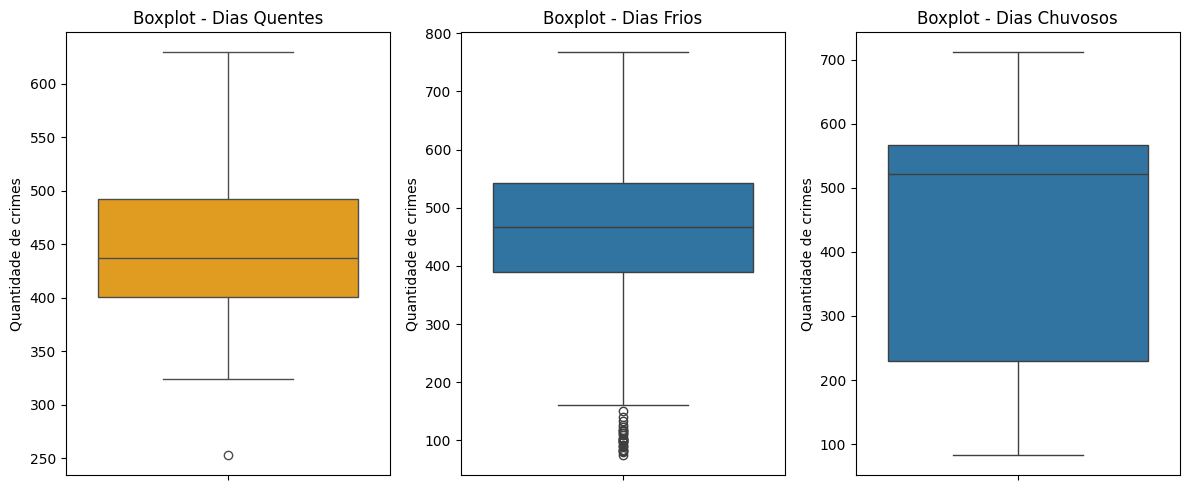

In [122]:
plt.figure(figsize=(12, 5)) 

# Primeiro gráfico (Dias Quentes)
plt.subplot(1, 3, 1)  
sns.boxplot(y=hot_days, color='orange')
plt.title('Boxplot - Dias Quentes')
plt.ylabel('Quantidade de crimes')

# Segundo gráfico (Dias Frios)
plt.subplot(1, 3, 2)  
sns.boxplot(y=cold_days)
plt.title('Boxplot - Dias Frios')
plt.ylabel('Quantidade de crimes')

# Segundo gráfico (Dias Frios)
plt.subplot(1, 3, 3)  
sns.boxplot(y=rainy_days)
plt.title('Boxplot - Dias Chuvosos')
plt.ylabel('Quantidade de crimes')

plt.tight_layout() #p evitar sobreposição
plt.show()

Histograma

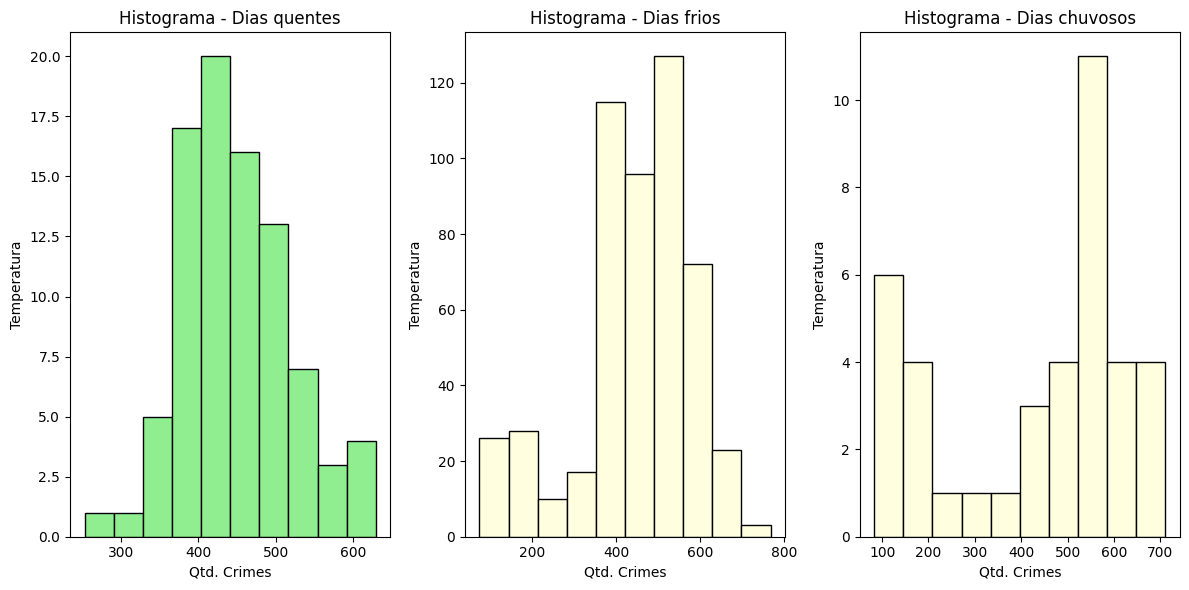

In [123]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.hist(hot_days, bins=10, color='lightgreen', edgecolor='black')
plt.title('Histograma - Dias quentes')
plt.ylabel('Temperatura')
plt.xlabel('Qtd. Crimes')

plt.subplot(1, 3, 2)
plt.hist(cold_days, bins=10, color='lightyellow', edgecolor='black')
plt.title('Histograma - Dias frios')
plt.ylabel('Temperatura')
plt.xlabel('Qtd. Crimes')

plt.subplot(1, 3, 3)
plt.hist(rainy_days, bins=10, color='lightyellow', edgecolor='black')
plt.title('Histograma - Dias chuvosos')
plt.ylabel('Temperatura')
plt.xlabel('Qtd. Crimes')

plt.tight_layout() 
plt.show()

QQ Plots

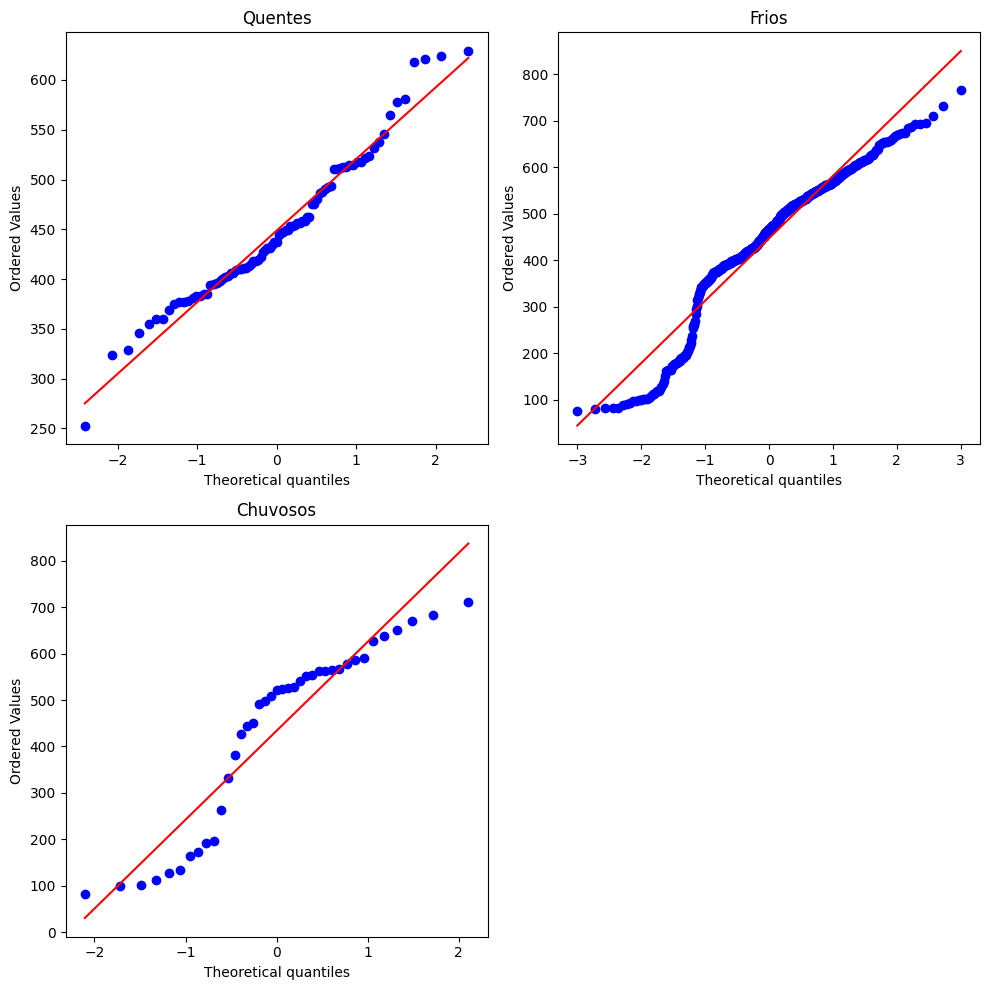

In [128]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

stats.probplot(hot_days, dist="norm", plot=ax[0,0])
ax[0,0].set_title('Quentes')

stats.probplot(cold_days, dist="norm", plot=ax[0,1])
ax[0,1].set_title('Frios')

stats.probplot(rainy_days, dist="norm", plot=ax[1,0])
ax[1,0].set_title('Chuvosos')

ax[1,1].axis('off')  # espaço vazio

plt.tight_layout()
plt.show()

## Análise preliminar

A partir das análises exibidas até então, observa-se que os dias que possuem maior índice de criminalidade não são os dias **mais quentes**, e sim os dias chuvosos, com a mediana apresentando os maiores valores na base de comparação com os 3 tipos de dias (quentes, frios e chuvosos).
O grupo de dias chuvosos se destaca por uma maior mediana, quartis superiores e uma maior dispersão, indicando que a ocorrência de crimes é mais frequente.

Em segundo lugar aparecem os dias frios, inferiores aos dias chuvosos, mas ainda maiores que os dias quentes.

Portanto, ao contrário da hipótese inicial indicando que temperaturas elevadas aumentariam a incidência de crimes, os resultados preliminares indicam que os dias quentes possuem a menor incidência dentre os grupos comparados, indicando que a condição climática mais propensa a aumentar o crime em Los Angeles é a chuva.

Testes inferenciais | Shapiro-Wilk

In [131]:
#dias quentes
shapiro_hot_days = stats.shapiro(hot_days)
print("Teste Shapiro-Wilk - x: W =", shapiro_hot_days.statistic, ", p-value =", shapiro_hot_days.pvalue)

Teste Shapiro-Wilk - x: W = 0.970749125995595 , p-value = 0.045853159045174716


*p-value = 0.046 < 0.05*  
Rejeita a H0, portanto os dados dos dias quentes **NÃO** seguem uma distribuição normal.

In [133]:
#dias frios
shapiro_cold_days = stats.shapiro(cold_days)
print("Teste Shapiro-Wilk - x: W =", shapiro_cold_days.statistic, ", p-valor =", shapiro_cold_days.pvalue)

Teste Shapiro-Wilk - x: W = 0.9367154883488082 , p-valor = 5.231048016350049e-14


*p-value = 5.23 > 0.05*  
Não rejeita a H0, portanto os dados dos dias quentes **SEGUEM** uma distribuição normal.

In [134]:
#dias chuvosos
shapiro_rainy_days = stats.shapiro(rainy_days)
print("Teste Shapiro-Wilk - x: W =", shapiro_rainy_days.statistic, ", p-valor =", shapiro_rainy_days.pvalue)

Teste Shapiro-Wilk - x: W = 0.8739775281404447 , p-valor = 0.00042950373140327125


*p-value = 0.0004 < 0.05*  
Rejeita a H0, portanto os dados dos dias quentes **NÃO** seguem uma distribuição normal.

## Observações  
  
Com os resultados obtidos não há necessidade de realizar testes paramétricos (Qui-Quadrado, Levene e, consequentemente, Testes t), pois não há normalidade entre os grupos, apenas 1 dos grupos apresentam distribuição normal. Também não é possível utilizar o qui-quadrado no momento pois não está sendo feita a análise de variáveis categóricas.

Foi realizada uma pesquisa sobre testes não-paramétricos para entender quais as melhores opções de testes para o cenário do projeto. 

Serão realizados testes de **Kruskal-Wallis** (alternativa para um teste ANOVA) para comparar 2 ou mais grupos e **Mann-Whitney** (alternativa para o teste t) para comparar pares posteriormente.

Testes não-paramétricos | Kruskal-Wallis

In [140]:
stat, p = kruskal(hot_days, cold_days, rainy_days)

stat, p

(np.float64(2.953657920599127), np.float64(0.2283606822462757))

*p_value = 0.29 > 0.05*  
Portanto, **NÃO HÁ** diferença significativa entre os grupos.

## Conclusão sobre essa parte das análises
O teste de Kruskal-Wallis indicou que não há evidências estatísticas o suficiente para apontar uma diferença significativa na incidência de crimes em dias quentes, frios e chuvosos. 
Apesar de o olho humano, ao observar os gráficos gerados, sugerir uma maior criminalidade nos dias frios e chuvosos, a evidência estatística não é suficiente para afirmar que a diferença seja real. 

## Respostas das perguntas iniciais
### 1. A média de crime diário aumenta quando está calor? 


In [149]:
mean_cold = cold_days.mean()
mean_rainy = rainy_days.mean()
mean_hot = hot_days.mean()

print(f"Média dia Frio: {mean_hot} | Média dia Chuvoso: {mean_rainy} | Média dia Quente: {mean_hot}. A média de crimes em dias quentes não aumenta.")


Média dia Frio: 448.632183908046 | Média dia Chuvoso: 433.7692307692308 | Média dia Quente: 448.632183908046. A média de crimes em dias quentes não aumenta.


### 2. Qual a probabilidade de que em um dia chuvoso tenha crime acima da mediana?

In [143]:
median = final_df['crime_count'].median() #mediana dos crimes observados

final_df['high_crime'] = final_df['crime_count'] > median  #variavel q vai dizer se os crimes tao acima da mediana ou n

rainy_days_total = final_df[final_df['rainy_day'] == True] #filtro pro total de dias chuvosos

prob_high_crime_rain = rainy_days_total['high_crime'].mean()

print(f"Probabilidade de: {prob_high_crime_rain}")

Probabilidade de: 0.5897435897435898


### 3. Qual a probabilidade de que em um dia quente tenha crime acima da mediana?

In [144]:
hot_days_total = final_df[final_df['hot_day'] == True]

prob_high_crime_hot = hot_days_total['high_crime'].mean()

print(f"Probabilidade de: {prob_high_crime_hot}")

Probabilidade de: 0.3563218390804598


### 4. Qual a probabilidade de que em um dia frio tenha crime acima da mediana?

In [145]:
cold_days_total = final_df[final_df['cold_day'] == True]

prob_high_crime_cold = cold_days_total['high_crime'].mean()

print(f"Probabilidade de: {prob_high_crime_cold}")

Probabilidade de: 0.5241779497098646


### 5. A dispersão de crimes muda entre dias quentes, frio e chuvosos?

In [151]:
#desvio padrao
dp_hot = hot_days.std()
dp_cold = cold_days.std()
dp_rainy = rainy_days.std()

#variancia
var_hot = hot_days.var()
var_cold = cold_days.var()
var_rainy = rainy_days.var()

#amplitude interquartil -- (Q3-Q1)
q1_hot = hot_days.quantile([0.25, 0.75]).values #.values transforma em array [Q1, Q3]
iqr_hot = q1_hot[1] - q1_hot[0]

q1_cold = cold_days.quantile([0.25, 0.75]).values 
iqr_cold = q1_cold[1] - q1_cold[0]

q1_rainy = rainy_days.quantile([0.25, 0.75]).values 
iqr_rainy = q1_rainy[1] - q1_rainy[0]


#coeficiente de variação
cv_hot = (dp_hot/mean_hot)*100
cv_cold = (dp_cold/mean_cold)*100
cv_rainy = (dp_rainy/mean_rainy)*100


#dataframe
df = pd.DataFrame({
    'Dia': ['Quente', 'Frio', 'Chuvoso'],
    'Média': [mean_hot, mean_cold, mean_rainy],
    'Variância': [var_hot, var_cold, var_rainy], 
    'DP': [dp_hot, dp_cold, dp_rainy], 
    'IQR': [iqr_hot, iqr_cold, iqr_rainy],
    'CV': [cv_hot, cv_cold, cv_rainy]
}).set_index('Dia')

df

,Média,Variância,DP,IQR,CV
Dia,,,,,
Quente,448.632184,5152.491045,71.780854,91.5,15.999934
Frio,447.433269,19053.920441,138.035939,153.0,30.850620
Chuvoso,433.769231,38822.024291,197.033054,336.0,45.423474


As medidas de dispersão indicam que a incidência de crimes variam mais em dias chuvosos, seguida pelos dias frios.  
Nos dias quentes, os valores variam menos, sugerindo uma maior estabilidade.